In [232]:
import json
from pandas.io.json import json_normalize
import pandas as pd
import datetime

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import time
import warnings
warnings.filterwarnings("ignore")

In [233]:
mv = pd.read_csv('e:/DS/data/ml/movies.csv',  sep=',')
tags = pd.read_csv('e:/DS/data/ml/tags.csv',  sep=',')
ln = pd.read_csv('e:/DS/data/ml/links.csv',  sep=',')
rt = pd.read_csv('e:/DS/data/ml/ratings.csv',  sep=',')


In [234]:
mv.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [235]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [236]:
ln.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [237]:
rt.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [238]:
mv.info(), rt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
movieId    9742 non-null int64
title      9742 non-null object
genres     9742 non-null object
dtypes: int64(1), object(2)
memory usage: 228.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
userId       100836 non-null int64
movieId      100836 non-null int64
rating       100836 non-null float64
timestamp    100836 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


(None, None)

In [239]:
#сколько всего пользователей
rt['userId'].nunique()

610

In [240]:
#количество фильмов
rt['movieId'].nunique()

9724

In [241]:
rt['rating'].min(),rt['rating'].max()

(0.5, 5.0)

### 2.Распределения количества оценок по фильмам и по пользователям

Распределение пользователей(посчитаем сколько отзывов оставил каждый пользователь, сгруппируем и посмотрим распределение)

In [434]:
#сколько отзывов оставил каждый пользоватлей
users_count = rt.groupby(['userId'], as_index=False)['rating'].count().add_prefix('cnt_').sort_values('cnt_rating')

                                     

In [435]:
users_count.reset_index()
users_count.head(), users_count.tail() 
users_count['cnt_rating'].min(), users_count['cnt_rating'].max()


(20, 2698)

In [436]:
users_count2 = users_count.groupby(['cnt_rating'], as_index=False).count().sort_values('cnt_userId')
users_count2= users_count2.rename(index=str, columns={"cnt_rating": "cnt_by_user", "cnt_userId": "cnt_users"})

In [447]:
def devide_group(x):
    if x>0 and x<=20:
        y=20
    elif x>20 and x<=30:
        y=30
    elif  x>30 and x<=50:
        y=50
    elif  x>50 and x<=100:
        y=100  
    elif  x>100 and x<=200:
        y=200
    elif  x>200 and x<=300:
        y=300    
    elif  x>300 and x<=500:
        y=500    
    elif x >500:
        y=600       
    return y

In [448]:
users_count2['group'] = users_count2['cnt_by_user'].apply(lambda x:devide_group(x) )

In [449]:
users_count3 = users_count2.groupby(['group'], as_index=False)['cnt_users'].sum().sort_values('group')

In [450]:
users_count3.head(15)

,group,cnt_users
0,20,14
1,30,98
2,50,120
3,100,133
4,200,112
5,300,50
6,500,40
7,600,43


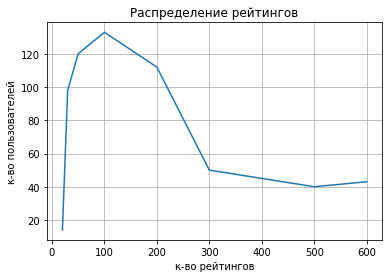

In [452]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
x = users_count3.group
y = users_count3.cnt_users

fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='к-во рейтингов', ylabel='к-во пользователей',
       title='Распределение рейтингов')
ax.grid()

fig.savefig("test.png")
plt.show()

Видим, что до 20 отзывов оставили всего 14 пользователей, после 200 резкое падение

##### Посмотрим распределение по фильмам

In [458]:
#сколько отзывов оставил каждый пользоватлей
movies_count = rt.groupby(['movieId'], as_index=False)['rating'].count().add_prefix('cnt_').sort_values('cnt_rating')
movies_count['cnt_rating'].min(), movies_count['cnt_rating'].max()
                                     

(1, 329)

In [464]:
movies_count2 = movies_count.groupby(['cnt_rating'], as_index=False).count().sort_values('cnt_movieId')
movies_count2= movies_count2.rename(index=str, columns={"cnt_rating": "cnt_rating", "cnt_movieId": "cnt_movies"})

In [470]:
def devide_group2(x):
    if x>0 and x<=20:
        y=20
    elif x>20 and x<=30:
        y=30
    elif  x>30 and x<=50:
        y=50
    elif  x>50 and x<=100:
        y=100  
    elif  x>100 and x<=150:
        y=150
    elif  x>150 and x<=200:
        y=200    
    elif  x>200 and x<=300:
        y=300    
    elif x >300:
        y=350       
    return y

In [471]:
movies_count2['group'] = movies_count2['cnt_rating'].apply(lambda x:devide_group2(x) )
movies_count3 = movies_count2.groupby(['group'], as_index=False)['cnt_movies'].sum().sort_values('group')

In [472]:
movies_count3

,group,cnt_movies
0,20,8489
1,30,375
2,50,424
3,100,302
4,150,91
5,200,25
6,300,15
7,350,3


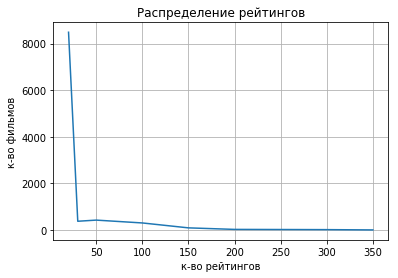

In [473]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
x = movies_count3.group
y = movies_count3.cnt_movies

fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='к-во рейтингов', ylabel='к-во фильмов',
       title='Распределение рейтингов')
ax.grid()

fig.savefig("test.png")
plt.show()

Видим, что большее количество фильмов имеет меньше 20 отзывов, а больше 150 всего 43 фильма

### 3.Оценить средние оценки по фильмам и рейтингам

In [456]:
agg = {
    'rating':{
        'mean',
        ''
    }
}
avr = rt.groupby(['movieId'], as_index=False)['rating'].agg(['mean', 'count'])

avr.iloc[3]

mean     2.357143
count    7.000000
Name: 4, dtype: float64

In [454]:
rt[rt['movieId']==4]

,userId,movieId,rating,timestamp
562,6,4,3.0,845554349
1386,14,4,3.0,835441653
13075,84,4,3.0,858772461
23702,162,4,3.0,836684306
38179,262,4,1.0,840306203
62011,411,4,2.0,835533021
95103,600,4,1.5,1237760055


In [328]:
df = pd.merge(rt,avr, how = 'inner',left_on="movieId" , right_on="movieId" )

In [330]:
avr2 = rt.groupby(['userId'], as_index=False)['userId', 'rating'].agg('mean')

In [331]:
df = pd.merge(df,avr2, how = 'inner',left_on="userId" , right_on="userId" )

In [333]:
df= df.rename(index=str, columns={"rating_x": "rating", "rating_y": "movie_mean", "rating_y": "user_mean"})

In [457]:
df.head()

,userId,movieId,rating,timestamp,mean,count,user_mean
0,1,1,4.0,964982703,3.920930,215,4.366379
1,1,3,4.0,964981247,3.259615,52,4.366379
2,1,6,4.0,964982224,3.946078,102,4.366379
3,1,47,5.0,964983815,3.975369,203,4.366379
4,1,50,5.0,964982931,4.237745,204,4.366379


### 4,5. Фильм нравится всем или никому

In [477]:
#нравятся всем, так как большинство фильмов имеет не больше 20 рейтингов
df[(df['mean']>=4.5)  &  (df['count']>=8)]['movieId'].unique() #sort_values('mean',ascending=False)

array([177593,   3451,   3201,   1041,   3152,   1178], dtype=int64)

In [476]:
#не нравятся никому
df[(df['mean']<=2.0)  &  (df['count']>=20)]['movieId'].unique() #sort_values('mean',ascending=False)

array([ 546, 1882, 1499], dtype=int64)

### 6. Смещение оценок пользователей

In [488]:
#отличение оценки пользователя от средней оценки фильма
df['user_std'] = df['rating'] - df['mean']

In [491]:
df2 = df.groupby(['userId'], as_index=False)['user_std'].agg(['sum', 'count', 'mean'])

In [495]:
#кто занижает оценки
df2[df2['mean']<-0.5]

,sum,count,mean
userId,,,
3,-44.816478,39,-1.149140
19,-366.369841,703,-0.521152
22,-139.244466,119,-1.170122
28,-317.106756,570,-0.556328
36,-47.525130,60,-0.792086
47,-74.280352,140,-0.530574
50,-215.355418,310,-0.694695
54,-20.992310,33,-0.636131
55,-19.403871,25,-0.776155


In [496]:
#те кто завышает оценки
df2[df2['mean']>=0.5]

,sum,count,mean
userId,,,
1,187.722845,232,0.809150
12,33.979681,32,1.061865
25,20.933721,26,0.805143
30,25.517260,34,0.750508
35,12.766654,23,0.555072
37,10.597083,21,0.504623
43,143.198415,114,1.256126
46,22.639784,42,0.539042
48,16.707587,33,0.506291


### 7.Постоим рекомендательную систему

In [363]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate, GridSearchCV
from surprise import Reader, Dataset, SVD, evaluate
from surprise.model_selection import train_test_split
from surprise import accuracy
import numpy as np

In [364]:
reader = Reader(rating_scale=(0.5, 5))  
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']],reader)

In [365]:
data

In [ ]:
param_grid = {
    'lr_all': [0.005, 0.05],
    'reg_all': [0.02, 0.002],
    'n_factors': [5, 10, 100, 500],
    'n_epochs': [10, 100]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

In [370]:
print(gs.best_score)

{'rmse': 0.8703370945631276, 'mae': 0.6665635539094863}


In [178]:
gs.best_params

{'rmse': {'lr_all': 0.05, 'reg_all': 0.02, 'n_factors': 500, 'n_epochs': 100},
 'mae': {'lr_all': 0.05, 'reg_all': 0.02, 'n_factors': 500, 'n_epochs': 100}}

In [180]:
svd = SVD(**gs.best_params['rmse'])

In [372]:
trainset, testset = train_test_split(data, test_size=.25)

In [373]:
svd.fit(trainset)


In [374]:
predictions = svd.test(testset)

In [ ]:
predictions

In [376]:
svd.predict(59, 1151)

Prediction(uid=59, iid=1151, r_ui=None, est=4.967434280236602, details={'was_impossible': False})

In [379]:
accuracy.rmse(predictions)

RMSE: 0.8632


0.8632217741663452

### 8.Получить рекомендации 

Рекомендации для существующего пользователя

In [380]:
iids = df['movieId'].unique()

In [381]:
iidsUser = df.loc[df['userId']==384, 'movieId']
iids_to_pred =  np.setdiff1d(iids,iidsUser) 

In [382]:
len(iids), len(iids_to_pred), len(iidsUser)

(9724, 9654, 70)

In [383]:
testset  = [[384, iid, 4.] for iid in iids_to_pred]
predictions = svd.test(testset)
predictions[2]

Prediction(uid=384, iid=3, r_ui=4.0, est=3.184148469069245, details={'was_impossible': False})

In [384]:
pred_ratings = np.array([pred.est for pred in predictions ])
i_max = pred_ratings.argmax()
iid = iids_to_pred[i_max]
print("Лучший фильм для этого пользователя {0} c предсказанным рейтингом  {1}".format(iid, pred_ratings[i_max]))

Лучший фильм для этого пользователя 858 c предсказанным рейтингом  4.869537186476973


Рекомендации для нового пользователя

In [400]:
testset  = [[615, iid, 4.] for iid in iids]
predictions = svd.test(testset)
predictions[0]

Prediction(uid=615, iid=1, r_ui=4.0, est=3.833357664235556, details={'was_impossible': False})

In [401]:
pred_ratings = np.array([pred.est for pred in predictions ])
i_max = pred_ratings.argmax()
iid = iids[i_max]
print("Лучший фильм для этого пользователя {0} c предсказанным рейтингом  {1}".format(iid, pred_ratings[i_max]))

Лучший фильм для этого пользователя 177593 c предсказанным рейтингом  4.353718920989347


In [404]:
# Этот фильм  входит в лучшие 
df[df['movieId']==177593]

,userId,movieId,rating,timestamp,mean,count,user_mean
1166,18,177593,4.5,1534007386,4.75,8,3.732072
19866,233,177593,5.0,1524781384,4.75,8,3.300000
35789,414,177593,4.5,1521844144,4.75,8,3.391957
72524,318,177593,4.5,1516826106,4.75,8,3.755973
85565,338,177593,5.0,1530148460,4.75,8,2.935897
92527,25,177593,5.0,1535470532,4.75,8,4.807692
94044,212,177593,5.0,1527794935,4.75,8,3.590726
97115,209,177593,4.5,1524522248,4.75,8,4.242857
